In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random
import cv2
import heapq
import time
import torch

from frechetdist import frdist
from refine_transform import match_fragments, Translation,check_possibility_of_translation, compute_fast_geom_morph_score,nms
from find_transform import estimate_transform_params, transform_line, estimate_mean_squared_transformation_error

from utils import build_fragment_from_directory, Fragment, rotate_fragment, pad_fragment
from utils import shift_fragment, blend_fragments, transform_fragment

from shape_align import align_two_fragments, pairwise_alignment, new_pairwise_alignment
from find_transform import find_best_transform_ransac, aligned_coords2line

from shape_utils import get_colorized_edge
from shape_utils import linearize_edge
from curvature import edge_coords2curvatures
from shape_align import water
from typing import List, Dict, Tuple
from joblib import Parallel, delayed
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
from dataclasses import dataclass
from scipy.ndimage import shift

In [2]:

from extend import extend_image, load_model

Detectron v2 is not installed


In [3]:
%matplotlib inline

# Extending fragment

In [8]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [9]:
# from skimage.io import imread
# from utils import preprocess

# def build_fragment(mask_index, model, indir='../voronoi/example', ext_step=30, pad=10):
#     fragment = imread(indir + '/' + 'fresco.jpg')
#     mask = imread(indir + '/' + f'new_mask_{mask_index}.png', as_gray=True) > 0.8
#     mask = mask[:,:,None]
#     cropped_frag, cropped_inv_mask, pos = preprocess(fragment, mask.astype(bool), ext_step=ext_step)
#     cropped_frag = np.pad(cropped_frag, ((pad, pad), (pad, pad), (0, 0)))
#     extended = cropped_frag
    
#     mask = np.invert(cropped_inv_mask)
#     extended_mask = cv2.dilate(mask * 1.0, np.ones((30, 30)))
#     extended_mask = np.pad(extended_mask, ((pad, pad), (pad, pad)))
#     extended_masked = extended_mask[:, :, None] * extended

#     mask = np.pad(mask, ((pad, pad), (pad, pad), (0, 0)))
#     mask = cv2.erode(mask * 1.0, np.ones((6, 6), np.uint8))[:,:,None]

#     return Fragment(cropped_frag / 255, extended_masked / 255,mask, extended_mask[:,:,None])

In [10]:
def pad_fragment_to_size(frag, size):
    h, w = frag.mask.shape[0], frag.mask.shape[1]
    pad_h, pad_w = (3 * size - h) // 2, (3 * size - w) // 2
    new_frag = Fragment(
        np.pad(frag.fragment, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)), (0, 0))),
        np.pad(frag.extended_frag, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)), (0, 0))),
        np.pad(frag.mask, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)))),
        np.pad(frag.extended_mask, ((pad_h, pad_h + 1 * (h % 2 != size % 2)), (pad_w, pad_w + 1 * (w % 2 != size % 2)))),
        frag.color_descriptor,
        frag.edge_coords,
        frag.edge_colors
    )
    new_frag.edge_coords[:,0] += pad_h
    new_frag.edge_coords[:,1] += pad_w
    return new_frag

In [11]:
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200)

In [12]:
frag1.fragment.shape, frag2.fragment.shape

((600, 600, 3), (600, 600, 3))

In [13]:
frag2.edge_coords[:,0].min(), frag2.edge_coords[:, 0].max()

(185, 414)

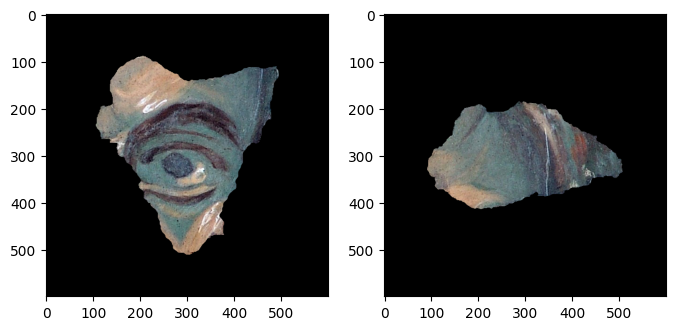

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [15]:
# def extend_fragment(frag, model):
#     inv_mask = np.invert(frag.mask.astype(bool))
#     extended = extend_image(frag.fragment * 255, inv_mask, model) * frag.extended_mask
#     return Fragment(
#         frag.fragment,
#         extended,
#         frag.mask,
#         frag.extended_mask
#     )

In [16]:
# model = load_model()

In [17]:
# ext_frag1 = extend_fragment(frag1, model)
# ext_frag2 = extend_fragment(frag2, model)

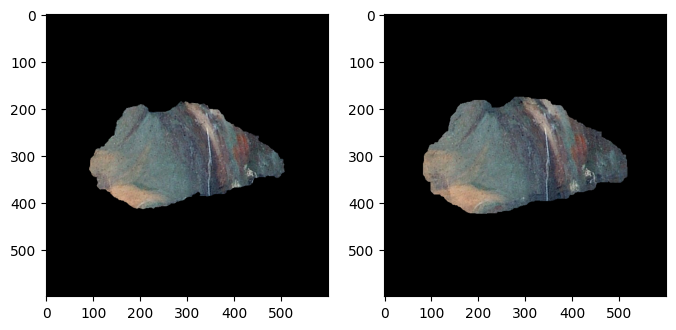

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag2.fragment)
axes[1].imshow(frag2.extended_frag)

In [19]:
frag1.edge_coords.shape

(2516, 2)

In [20]:

# frag3 = rotate_fragment(pad_fragment_to_size(frag1, 300), 60)

# Matching fragments

In [21]:
from shape_utils import ShapeDescriptor
from shape_align import find_best_transform_ransac, aligned_coords2line, fragments2shape_descriptors
from shape_align import Alignment

In [22]:
def find_best_fragment_transform(palette, frag1, frag2):
    frags = [frag1, frag2]
    descriptors, alignment = pairwise_alignment(palette, frags)
    line1 = aligned_coords2line(alignment[(0, 1)], descriptors[0].edge_coords, left=True)
    line2 = aligned_coords2line(alignment[(0, 1)], descriptors[1].edge_coords[::-1], left=False)
    line1 -= frag1.fragment.shape[0] // 2
    line2 -= frag2.fragment.shape[0] // 2
    best_transform = find_best_transform_ransac(line1, line2)
    return best_transform, line1, line2 

def estimate_max_squared_transformation_error(line1, line2, trasform_params):
    """
    line1, line2 - np.arrays, shape (n, 2)
    transforms_params - tuple (cos, sin, a, b) of transform parameters line1 -> line2
    returns mean squared error
    """
    transformed_line1 = transform_line(line1, trasform_params)
    return np.linalg.norm(line2 - transformed_line1, axis=1).max()

def iou(indices1, indices2):
    set1 = set([tuple(p) for p in indices1])
    set2 = set([tuple(p) for p in indices2])
    iou = len(set1.intersection(set2)) / len(set1.union(set2))
    return iou

def alignment_nms(aligns, edge_coords1, edge_coords2):
    aligns.sort(key=lambda x: x.conf, reverse=False)
    align_coords1 = [aligned_coords2line(aligns[i].indices, edge_coords1, left=True) for i in range(len(aligns))]
    align_coords2 = [aligned_coords2line(aligns[i].indices, edge_coords2[::-1], left=False) for i in range(len(aligns))]
    i = 0
    while i < len(aligns):
        j = i + 1
        while j < len(aligns):
            iou_score = (iou(align_coords1[i], align_coords1[j]) + iou(align_coords2[i], align_coords2[j])) / 2
            
#             print(i, '-', j, ':', iou_score)
            if iou_score > 0.9:
                aligns.pop(j)
            else:
                j += 1
        i += 1
    return aligns

def backtrace(
    pointer,
    score,
    seq1, seq2,
    block_i, block_j, 
    block_size_y, block_size_x
):
    roi = score[block_i * block_size_y : (block_i + 1) * block_size_y, block_j * block_size_x : (block_j + 1) * block_size_x]
    argmax = np.argmax(roi)
    max_i, max_j = np.unravel_index(argmax, roi.shape)
    max_i, max_j = max_i + block_i * block_size_y, max_j + block_j * block_size_x
#     print(roi.shape, roi.max(), argmax, max_i, max_j)
    
    indices = []
    i, j = max_i, max_j
    while pointer[i][j] > 0:
        indices.append((i, j))
        if pointer[i][j] == 3:
            i -= 1
            j -= 1
        elif pointer[i][j] == 2:
            j -= 1
        elif pointer[i][j] == 1:
            i -= 1
    return np.array(indices)

def generate_multiple_alignments(pointer, score, dsc1, dsc2, blocks_num):
    block_size_y = int(pointer.shape[0] / blocks_num)
    block_size_x = int(pointer.shape[1] / blocks_num)
    color_edge1 = dsc1.color_edge
    color_edge2 = dsc2.color_edge
    edge_coords1 = dsc1.edge_coords
    edge_coords2 = dsc2.edge_coords

    best_indices = None
    best_mse = 10000
    aligns = []
    for i in range(blocks_num):
        for j in range(blocks_num):
            indices = backtrace(pointer, score, color_edge1, color_edge2[::-1], i, j, block_size_y, block_size_x)
            if len(indices) < 25:
                continue
            line1 = aligned_coords2line(indices, edge_coords1, left=True)
            line2 = aligned_coords2line(indices, edge_coords2[::-1], left=False)
            best_transform = find_best_transform_ransac(line1, line2)
            if best_transform is None:
                continue
            mse = estimate_max_squared_transformation_error(line1, line2, best_transform)
            aligns.append(Alignment(indices, mse))
    print(len(aligns))
    aligns = alignment_nms(aligns, edge_coords1, edge_coords2)
    print(len(aligns))
    return aligns

def new_pairwise_alignment(palette, fragments: List, blocks_num=5) -> Tuple[List[ShapeDescriptor], Dict[Tuple[int, int], np.ndarray]]:
    """Compute pairwise alignment between fragments.

    Args:
        fragments: List of fragments.
    """
    print("Computing shape descriptors...")
    shape_descriptors = fragments2shape_descriptors(palette, fragments)
    print("Computing pairwise alignments...")
    alignment_dict = {}
    for i, frag1 in enumerate(fragments):
        for j, frag2 in enumerate(fragments):
            if j > i:
                indices, pointer, score = align_two_fragments(
                    palette,
                    frag1, frag2, 
                    to_print=f"Aligning fragments {i} and {j}:", 
                    shape_descriptor1=shape_descriptors[i], 
                    shape_descriptor2=shape_descriptors[j]
                )
                aligns = generate_multiple_alignments(pointer, score, shape_descriptors[i], shape_descriptors[j], blocks_num)
                alignment_dict[(i, j)] = aligns
    
    return shape_descriptors, alignment_dict

In [23]:
frags = [frag1, frag2]


In [24]:
descriptors, alignment = new_pairwise_alignment(palette,frags, blocks_num=3)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:14<00:00, 174.68it/s]


9
1


In [25]:
align_index = 0
l, r = 0, 1

In [26]:
alignment[(l, r)]

In [27]:
def transform_line(line, trasform_params):
    """
    line - np.array, shape (n, 2)
    trasform_params - tuple (cos, sin, a, b) of transform parameters line -> line
    returns transformed line
    """
    cos, sin, a, b = trasform_params
    cos = min(cos, 1)
    cos = max(cos, -1)
    sin = np.sqrt(1 - cos**2) if sin > 0 else -np.sqrt(1 - cos**2)
    transformed_line = np.zeros(line.shape)
    transformed_line[:, 0] = line[:, 0] * cos - line[:, 1] * sin + a
    transformed_line[:, 1] = line[:, 0] * sin + line[:, 1] * cos + b
    return transformed_line


In [28]:
def find_best_transform_ransac(line1, line2):
    length = min(line1.shape[0], line2.shape[0])
    min_error = 10000
    best_transform = None
    
    for i in range(1000):
        l = random.choice(range(length))
        if (length - l) <= 25: 
            continue
        r = random.choice(range(l + 25, length))
        if r - l < 25: 
            continue
        try: 
            dist = np.linalg.norm(line1[l] - line1[r])
            distances = np.abs(np.linalg.norm(line2 - line2[l], axis=1) - dist)
            distances[:l] = 10000
            best_point = np.argmin(distances)
            
            transform_params = estimate_transform_params(line1[l], line1[r], line2[l], line2[best_point])
        except Exception as e:
#             raise e
            continue
        error = estimate_max_squared_transformation_error(line1, line2, transform_params)
        
        if error < min_error:
#             print("new best error", error, "at ", l, r, " with ", transform_params)
#             print(line1[l], line1[r], line2[l], line2[best_point], np.linalg.norm(line1[l] - line1[r]), np.abs(np.linalg.norm(line2[l] - line2[best_point])))
            min_error = error
            best_transform = transform_params
    return best_transform

In [29]:
alignment[(l, r)]

In [31]:
align_index = 0
alignment[(l, r)][align_index].conf

6.083355526879088

In [32]:
line1 = aligned_coords2line(alignment[(l, r)][align_index].indices, descriptors[l].edge_coords, left=True)
line2 = aligned_coords2line(alignment[(l, r)][align_index].indices, descriptors[r].edge_coords[::-1], left=False)
line1 -= frag1.fragment.shape[0] // 2
line2 -= frag2.fragment.shape[0] // 2
best_transform_params = find_best_transform_ransac(line1, line2)

In [33]:
best_transform_params

array([ 1.00081087e+00, -3.18264748e-02,  2.71906142e+02, -1.18066086e+02])

In [34]:
cos = best_transform_params[0]
cos = max(cos, -1)
cos = min(cos, 1)
np.rad2deg(np.arccos(cos))

0.0

In [35]:
theta, shift_y, shift_x = -np.rad2deg(np.arccos(cos)), best_transform_params[2], best_transform_params[3]

In [36]:
print(theta, shift_y, shift_x)

-0.0 271.9061423069126 -118.0660855463207


In [37]:
from skimage.transform import rotate
def rotate_fragment(frag, angle):
    return Fragment(
        rotate(frag.fragment, angle),
        rotate(frag.extended_frag, angle),
        rotate(frag.mask, angle),
        rotate(frag.extended_mask, angle),
    )

1.0
255


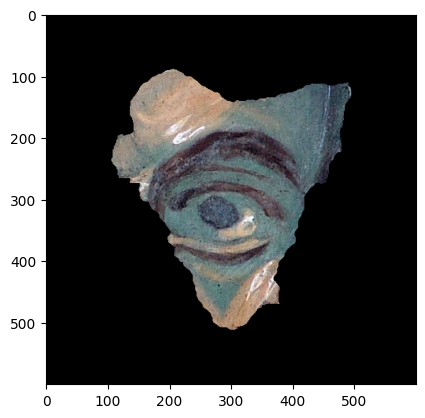

In [38]:
rot_frag = rotate_fragment(frag1, theta)
plt.imshow(rot_frag.fragment)
print(rot_frag.fragment.max())
print(frag1.fragment.max())

In [39]:
def normalize_fragment(frag):
    return Fragment(
        frag.fragment / 255,
        frag.extended_frag / 255,
        frag.mask / 255,
        frag.extended_mask / 255,
        frag.color_descriptor,
        frag.edge_coords,
        frag.edge_colors
    )

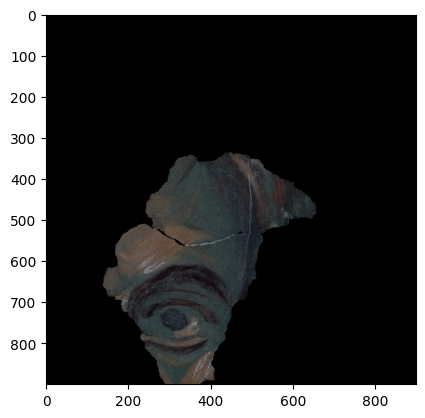

In [40]:
blended = blend_fragments(
    normalize_fragment(pad_fragment_to_size(frag2, 300)),
    shift_fragment(
        rotate_fragment(pad_fragment_to_size(frag1, 300), theta), 
        int(shift_x),
        int(shift_y)
    )
)
plt.imshow(blended.fragment)

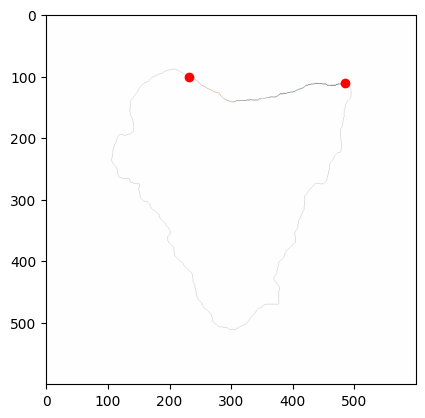

In [41]:
# common_edge = np.ones((frags[l].fragment.shape[0] * 2, frags[l].fragment.shape[1] * 2, 3))
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignment[(l, r)][align_index].indices
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
#     print(point)
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[i - 1]
    y, x = edge_coords[i - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

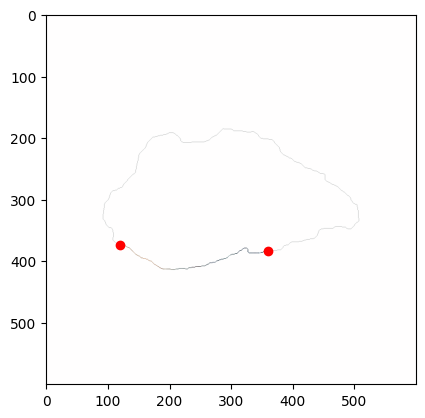

In [42]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
indices = alignment[(l, r)][align_index].indices
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

# Refine 

In [43]:
def compute_content_score(frag1, frag2):
    img1, img2 = frag1.extended_frag, frag2.extended_frag
#     img1 = (img1 - img1.min()) / (img1.max() - img1.min()) - 0.5
#     img2 = (img2 - img2.min()) / (img2.max() - img2.min())
    where = np.logical_and(frag1.extended_mask, frag2.extended_mask)
    img1 = (img1 - 0.5) * where
    img2 = (img2 - 0.5) * where
#     img1, img2 = img1 / img1.max() - 0.5, img2 / img2.max() - 0.5 
    cov = (img1 * img2).sum()
    corr = cov / np.sqrt((img1 ** 2).sum() * (img2 ** 2).sum())
    return corr

def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift):
    """
    frag1 - fragment
    frag2 - transformed fragment
    features1 - frag1 features from pre-trained model, shape (n_features, height, width)
    features2 - frag2 features from pre-trained model, shape (n_features, height, width)
    shift - translation (shift_x, shift_y)
    """
#     img_cross_corr = compute_content_score(frag1, frag2)
    pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
    padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
    padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
    shifted_features2 = padded_features2[:,pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
#     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)[:, None, None]

    padded_mask2 = np.pad(resized_mask2, ((pad, pad), (pad, pad), (0, 0)))
    shifted_mask2 = padded_mask2[pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
    
    where = np.logical_and(resized_mask1, shifted_mask2).transpose(2, 0, 1)
    features1_masked = features1 * where
    features2_masked = shifted_features2 * where
    features_cov = (features1_masked * features2_masked).sum()
    features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
    return features_cross_corr
#     cross_corr = (img_cross_corr + features_cross_corr) / 2
#     return cross_corr
    
def compute_fast_geom_morph_score(subcurve1, subcurve2, transform_params, max_distance=30):
    """
    subcurve1: (n, 2) array, common subcurve from frag1
    subcurve2: (n, 2) array, common subcurve from frag2
    transform_params: tuple of (theta, shift_x, shift_y)
    """
    theta, shift_x, shift_y = transform_params
    transformed_subcurve = np.zeros(subcurve1.shape)
    theta_rad = np.deg2rad(theta)
    transformed_subcurve[:, 0] = subcurve1[:, 0] * np.cos(theta_rad) - subcurve1[:, 1] * np.sin(theta_rad) + shift_y
    transformed_subcurve[:, 1] = subcurve1[:, 0] * np.sin(theta_rad) + subcurve1[:, 1] * np.cos(theta_rad) + shift_x
    score = (max_distance - np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1))) / max_distance
#     print(np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1)))
    return score ** (1 / 3) if score > 0 else 0

In [50]:
def match_two_aligned_fragments(frag1, frag2, list_of_initial_params, subcurves1, subcurves2, beta=0.5, pad_size=200, verbose=1):
    """
    list_of_initial_params: list of (angle, x, y)
    frag1, frag2: Fragments
    subcurves1, subcurves2: common subcurves from frag1 and frag2, each corresponds to initial_params
    """
    padded_frag1 = pad_fragment_to_size(frag1, pad_size)
    padded_frag2 = pad_fragment_to_size(frag2, pad_size)
    
    tensor1 = torch.tensor(padded_frag1.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
    features1 = feature_extractor(tensor1)
    features1 = features1.squeeze(0).detach().numpy()
    
#     resized_mask1 = skimage.transform.resize(
#         padded_frag1.extended_mask,
#         (padded_frag1.fragment.shape[0] // 2, padded_frag1.fragment.shape[1] // 2)
#     )
    
    global_res = []
    
    for params_index, initial_params in enumerate(list_of_initial_params):
        theta, x_initial, y_initial = initial_params
        subcurve1 = subcurves1[params_index]
        subcurve2 = subcurves2[params_index]
        
        shifts = [(x, y) for x in range(x_initial - 30, x_initial + 31, 5) for y in range(y_initial - 30, y_initial + 31, 5)]
        for phi in np.arange(theta - 8, theta + 9, 4):
            rot_frag2 = rotate_fragment(padded_frag2, phi)
            tensor2 = torch.tensor(rot_frag2.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
            features2 = feature_extractor(tensor2)
            features2 = features2.squeeze(0).detach().numpy()
#             resized_mask2 = skimage.transform.resize(
#                 rot_frag2.extended_mask, 
#                 (rot_frag2.fragment.shape[0] // 2, rot_frag2.fragment.shape[1] // 2)
#             )

            good_shifts = []
            for (x, y) in tqdm(shifts) if verbose == 1 else shifts:
                transformed2 = shift_fragment(rot_frag2, x, y)
                if check_possibility_of_translation(padded_frag1, transformed2):
                    geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
                    prob = geom_score
#                     print(prob)
                    if prob > 0.5:
#                         content_score = compute_new_content_score(
#                             padded_frag1, transformed2,
#                             features1, features2,
#                             resized_mask1, resized_mask2,
#                             (x, y)                        
#                         )
#                         prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)

#                         print(geom_score, content_score, prob)
#                         trans = Translation(x, y, phi, prob)
#                         global_res.append(trans)
                        if prob > 0.5:
                            good_shifts.extend([(x_new, y_new) for x_new in range(x - 2, x + 3, 2) for y_new in range(y - 2, y + 3, 2)])
            for (x, y) in tqdm(good_shifts) if verbose == 1 else good_shifts:
                transformed2 = shift_fragment(rot_frag2, x, y)
                if check_possibility_of_translation(padded_frag1, transformed2):
                    geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
                    prob = geom_score
#                     print(prob)
                    if prob > 0.5:
                        content_score = compute_new_content_score(
                            padded_frag1, transformed2,
                            features1, features2,
                            padded_frag1.extended_mask, transformed2.extended_mask,
                            (x, y)                        
                        )
                        prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
                        trans = Translation(x, y, phi, prob)
                        global_res.append(trans)
            
    filtered_res = nms(sorted(global_res, reverse=True, key=lambda val: val.confidence).copy())
    return filtered_res

In [45]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)
conv = mobilenet.features[0][0]
conv.stride = (1, 1)
feature_extractor = conv
feature_extractor.requires_grad_(False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [46]:
list_of_initial_params = []
subcurves1 = []
subcurves2 = []
for indices in alignment[(l, r)]:
    line1 = aligned_coords2line(indices.indices, descriptors[l].edge_coords, left=True)
    line2 = aligned_coords2line(indices.indices, descriptors[r].edge_coords[::-1], left=False)
    line1 -= frags[l].fragment.shape[0] // 2
    line2 -= frags[r].fragment.shape[0] // 2
    best_transform_params = find_best_transform_ransac(line1, line2)
    cos = max(cos, -1)
    cos = min(cos, 1)
    theta, shift_y, shift_x = -np.rad2deg(np.arccos(cos)), best_transform_params[2], best_transform_params[3]
    list_of_initial_params.append((theta, int(shift_x), int(shift_y)))
    subcurves1.append(line1)
    subcurves2.append(line2)

In [51]:
start_time = time.time()
res = match_two_aligned_fragments(
    pad_fragment_to_size(frag2, 300),
    pad_fragment_to_size(frag1, 300),
    list_of_initial_params,
    subcurves1,
    subcurves2,
    pad_size=300,
    verbose=1
)
print("--- %s seconds ---" % (time.time() - start_time))

100%|█████████████████████████████████████████████████████████████████████████████████| 169/169 [00:02<00:00, 63.79it/s]
0it [00:00, ?it/s]
  2%|█▌                                                                                  | 1/54 [00:01<00:57,  1.09s/it]


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2)  and requested shape (2,2)

In [36]:
res

[Translation(x=211, y=38, angle=-4.0000020913097885, confidence=nan),
 Translation(x=221, y=21, angle=-2.0913097884545095e-06, confidence=nan)]

In [37]:
padded_frag2 = pad_fragment(ext_frag2, 300)

In [38]:
def visualize_fragment(frag):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
    axes[0][0].imshow(frag.fragment)
    axes[0][1].imshow(frag.mask * 255)
    axes[1][0].imshow(frag.extended_frag)
    axes[1][1].imshow(frag.extended_mask * 255)

nan -4.0000020913097885 211 38


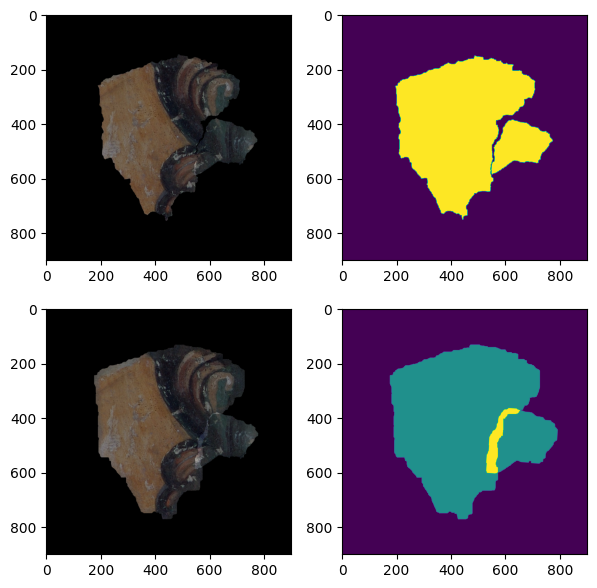

In [39]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
print(tr.confidence, tr.angle, tr.x, tr.y)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(pad_fragment(frag1, 300), tr.angle), x, y)
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)

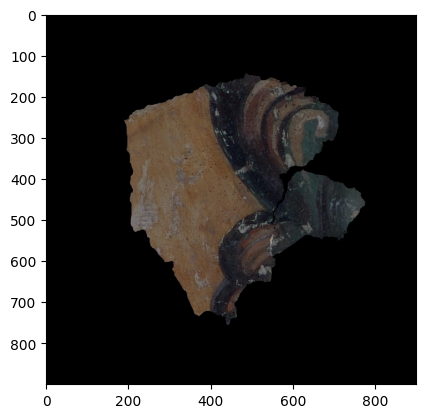

In [41]:
plt.imshow(blended.fragment)

In [431]:
# mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# feature_extractor = torch.nn.Sequential(
#     mobilenet.features[0],
# )

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [435]:
# conv = mobilenet.features[0][0]
# conv.stride = (1, 1)
# conv

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [48]:

tensor = torch.tensor(ext_frag2.extended_frag, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
features = conv(tensor)
features = features.squeeze(0).detach().numpy()

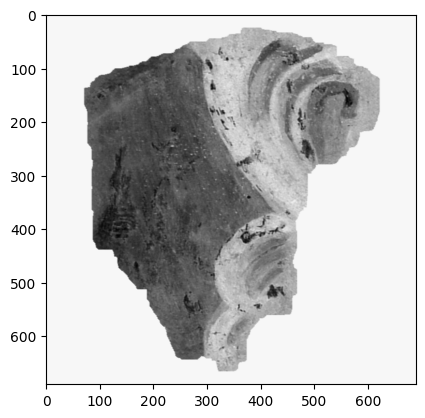

In [60]:
plt.imshow(features[17], cmap='gray')

In [457]:
feature_extractor = conv

# Pairwise 2-stage matching

In [140]:
frags = [
    build_fragment(9, None), 
    build_fragment(11, None), 
#     build_fragment(14, None), 
#     build_fragment(15, None),
#     build_fragment(10, None),
]

In [141]:
start_time = time.time()
ext_frags = [extend_fragment(frag, model) for frag in frags]
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.560958862304688 seconds ---


In [142]:
start_time = time.time()
descriptors, alignments = new_pairwise_alignment(palette,ext_frags)
print("--- %s seconds ---" % (time.time() - start_time))

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 2479/2479 [00:11<00:00, 224.50it/s]


25
4
--- 26.594480514526367 seconds ---


In [143]:
start_time = time.time()
refined_alignment = {}
for l in range(len(frags)):
    for r in range(l + 1, len(frags)):
        print("Refining transform between {} and {}".format(l, r))
        
        list_of_initial_params = []
        subcurves1 = []
        subcurves2 = []
        for alignment in alignments[(l, r)]:
            line1 = aligned_coords2line(alignment.indices, descriptors[l].edge_coords, left=True)
            line2 = aligned_coords2line(alignment.indices, descriptors[r].edge_coords[::-1], left=False)
            line1 -= ext_frags[l].fragment.shape[0] // 2
            line2 -= ext_frags[r].fragment.shape[0] // 2
            best_transform_params = find_best_transform_ransac(line1, line2)
            cos = best_transform_params[0]
            cos = min(cos, 1)
            cos = max(cos, -1)
            theta, shift_y, shift_x = -np.rad2deg(np.arccos(cos)), best_transform_params[2], best_transform_params[3]
            list_of_initial_params.append((theta, int(shift_x), int(shift_y)))
            subcurves1.append(line1)
            subcurves2.append(line2)
    
        res = match_two_aligned_fragments(
            pad_fragment(ext_frags[l], 200),
            pad_fragment(ext_frags[r], 200),
            list_of_initial_params,
            subcurves1,
            subcurves2
        )
        print(len(res))
        if len(res) > 0:
            tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
            refined_alignment[(i, j)] = tr
print("--- %s seconds ---" % (time.time() - start_time))

Refining transform between 0 and 1


100%|█████████████████████████████████████████████████████████████████████████████████| 169/169 [00:02<00:00, 56.96it/s]

2
--- 43.61273217201233 seconds ---


In [145]:
refined_alignment

{(0,
  1): Translation(x=59, y=-278, angle=-177.0, confidence=0.5374374436156218)}

In [149]:
l, r = 0, 1

0.5374374436156218


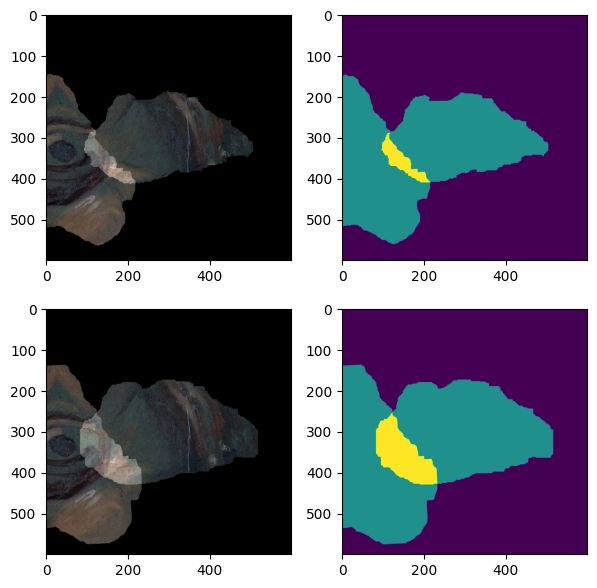

In [151]:
print(tr.confidence)
padded_frag2 = pad_fragment(ext_frags[r], 200)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(pad_fragment(ext_frags[l], 200), tr.angle), y, x)
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)